# PACE L2 for AVUELO

In [123]:
# Load Modules
import earthaccess
import xarray as xr
from xarray.backends.api import open_datatree
import matplotlib.pyplot as plt
import cartopy
import numpy as np
import h5netcdf
from IPython.display import JSON
import geopandas as gpd
from shapely.geometry import Point, LineString
import re
import pandas as pd
import seaborn as sns

In [124]:
# Authentification
auth = earthaccess.login(persist=True)

## PACE: Level 2 - BGC

In [125]:
# PACE Search Criteria
tspan = ("2025-02-17", "2025-02-18")
bbox=(-84.951187, 9.645435, -84.653903, 9.954900)

# Search for PACE Imagery
results = earthaccess.search_data(
    short_name="PACE_OCI_L2_BGC_NRT",
    temporal=tspan,
    bounding_box=bbox,
)

# Pull from Cloud
paths = earthaccess.open(results)

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

In [66]:
# Functions 
def process_l2(path):
    
    prod = xr.open_dataset(path)
    obs = xr.open_dataset(path, group="geophysical_data")
    nav = xr.open_dataset(path, group="navigation_data")
    nav = (
        nav
        .set_coords(("longitude", "latitude"))
    )
    dataset = xr.merge((prod, obs, nav.coords))

    return dataset

In [63]:
# Chlorophyll 
dataset = process_l2(paths[0])
array = np.log10(dataset["chlor_a"])
array.attrs.update(
    {
        "units": f'log10({dataset["chlor_a"].attrs["units"]})',
    }
)

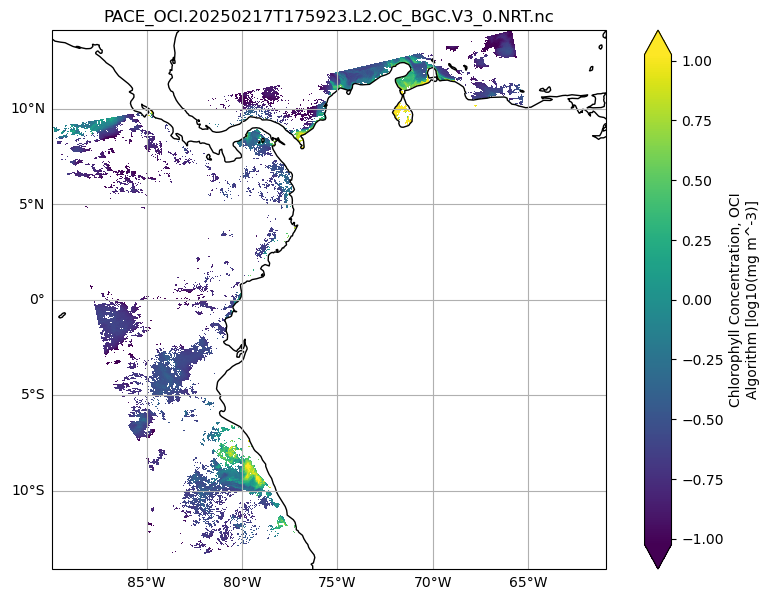

In [81]:
# Full PACE Image
fig = plt.figure(figsize=(10, 7))
ax = plt.axes(projection=cartopy.crs.PlateCarree())
array.plot(x="longitude", y="latitude", cmap="viridis", robust=True, ax=ax)
ax.coastlines()
ax.gridlines(draw_labels={"bottom": "x", "left": "y"})
ax.set_title(dataset.attrs["product_name"], loc="center")
plt.show()

In [82]:
# PACE Subset
S = 9.4
N = 10.5
W = -84.951187
E = -84.653903

# Chlorophyll Box 
chl_box = np.log(dataset["chlor_a"]).where(
    (
        (dataset["latitude"] > S)
        & (dataset["latitude"] < N)
        & (dataset["longitude"] > W)
        & (dataset["longitude"] < E)
    ),
    drop=True,
)
chl_box.attrs.update(
    {
        "units": f'log10({dataset["chlor_a"].attrs["units"]})',
    }
)

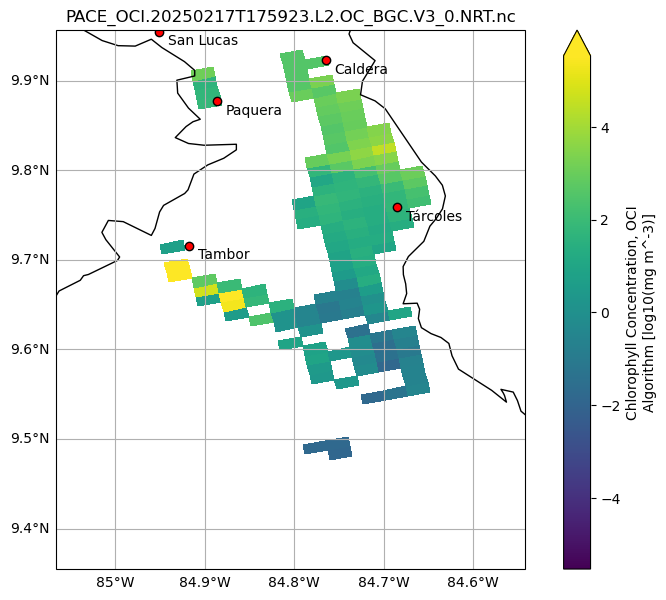

In [103]:
# Plot PACE Chlorophyll and Boat Locations

fig = plt.figure(figsize=(10, 7))
ax.set_extent([-85.5, -84.5, 9.45, 10.0], crs=ccrs.PlateCarree())

ax = plt.axes(projection=cartopy.crs.PlateCarree())
chl_box.plot(x="longitude", y="latitude", cmap="viridis",
             robust=True, ax=ax)
ax.coastlines()
ax.gridlines(draw_labels={"bottom": "x", "left": "y"})
ax.set_title(dataset.attrs["product_name"], loc="center")

# Day 1 Stations
day1_sites = {'Tárcoles': {'lat': 9.758708, 'lon': -84.685542},
              'Caldera': {'lat': 9.923492, 'lon': -84.764755},
              'San Lucas': {'lat': 9.954900, 'lon':-84.951187},
              'Paquera': {'lat': 9.877386, 'lon': -84.886358},
              'Tambor': {'lat': 9.716024, 'lon': -84.917416}}

for site, coords in day1_sites.items():
    ax.plot(coords['lon'], coords['lat'], marker='o', color='red', markersize=6, markeredgecolor='black', markeredgewidth=1, transform=ccrs.PlateCarree())
    ax.text(coords['lon'] + 0.01, coords['lat'] - 0.015, site, fontsize=10, transform=ccrs.PlateCarree())

fig.savefig('figures/' + dataset.attrs["product_name"] + '.png', dpi=600)

## PACE L2: AOP 

In [126]:
# PACE Search Criteria
tspan = ("2025-02-17", "2025-02-18")
bbox=(-84.951187, 9.645435, -84.653903, 9.954900)

# Search for PACE Imagery
results = earthaccess.search_data(
    short_name="PACE_OCI_L2_AOP_NRT",
    temporal=tspan,
    bounding_box=bbox,
)

# Pull from Cloud
paths = earthaccess.open(results)

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

In [140]:
# Pull Rrs
dataset = xr.open_dataset(paths[0], group="geophysical_data")
rrs = dataset["Rrs"]

# Pull coordinate data
dataset = xr.open_dataset(paths[0], group="navigation_data")
dataset = dataset.set_coords(("longitude", "latitude"))
dataset = xr.merge((rrs, dataset.coords))

# Pull Wavelength data
wl_dataset = xr.open_dataset(paths[0], group="sensor_band_parameters")
wl = wl_dataset['wavelength_3d'].values

# Formatting Data
match = re.search(r"(PACE_OCI\.[^/,]+\.nc)", paths[0].details['name'])
if match:
    filename = match.group(1)

date = re.search(r"\d{8}", filename).group()

## Plot Spectra for Bounding Box

In [159]:
# Subset for bounding box
rrs_box = dataset["Rrs"].where(
    (
        (dataset["latitude"] > S)
        & (dataset["latitude"] < N)
        & (dataset["longitude"] > W)
        & (dataset["longitude"] < E)
    ),
    drop=True,
)

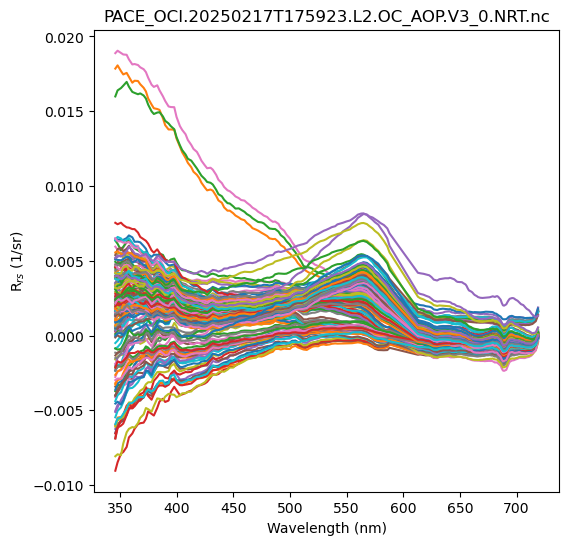

In [161]:
# All Pixels in Subset Region  
rrs_stack = rrs_box.stack(
    {"pixel": ["number_of_lines", "pixels_per_line"]}, create_index=False,
)

fig, ax = plt.subplots(figsize=(6, 6))  # Ensures a square figure
for pixel in rrs_stack['pixel'].values:  # Iterate over pixels
    ax.plot(wl, rrs_stack.sel(pixel=pixel), label=f"Pixel {pixel}")
    
ax.set_xlabel("Wavelength (nm)")  # Label the new x-axis
ax.set_ylabel(r"R$_{rs}$ (1/sr)")  # Adjust if necessary
ax.set_title(filename, loc="center")
fig.savefig('figures/' + filename + '_rrs_.png', dpi=600)

## Plot Spectra for Boat Sites

In [178]:
# Define the function to extract spectra for a given lat/lon
def target_spectra(target_lat, target_lon):
    # Compute the absolute differences
    lat_diff = np.abs(dataset["latitude"] - target_lat)
    lon_diff = np.abs(dataset["longitude"] - target_lon)
    
    # Get the combined difference and find the minimum
    distance = lat_diff + lon_diff  # Total difference in lat/lon space
    nearest_point = distance.argmin(dim=("number_of_lines", "pixels_per_line"))  # Find index of the minimum
    
    # Extract the nearest Rrs value
    nearest_rrs = dataset["Rrs"].isel(
        number_of_lines=nearest_point["number_of_lines"], 
        pixels_per_line=nearest_point["pixels_per_line"]
    )
    
    return nearest_rrs
    
# Loop through each site and collect spectra
spectra_list = []
for site_name, coords in day1_sites.items():
    nearest_rrs = target_spectra(coords['lat'], coords['lon'])
    
    # Convert to DataFrame and add site name
    site_df = nearest_rrs.to_dataframe().reset_index()
    site_df["Site"] = site_name
    site_df["wl"] = wl
    
    spectra_list.append(site_df)

# Combine all sites into a single DataFrame
spectra_df = pd.concat(spectra_list, ignore_index=True)

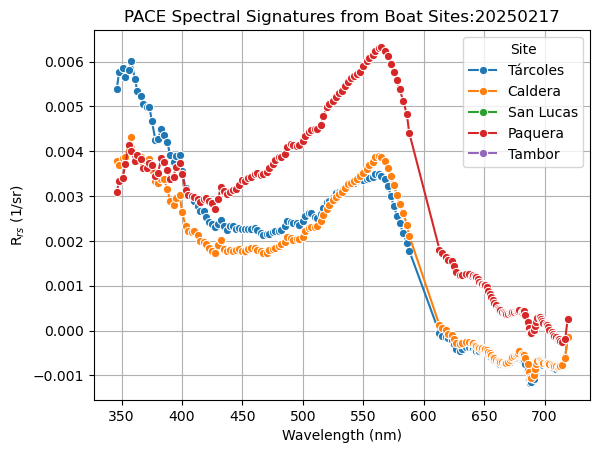

In [189]:
# Check column names to identify wavelength and Rrs values
wavelength_col = "wl" if "wl" in spectra_df.columns else spectra_df.columns[1]  # Adjust if needed
rrs_col = "Rrs" if "Rrs" in spectra_df.columns else spectra_df.columns[-2]  # Adjust if needed

fig,ax = plt.subplots(1,1)
sns.lineplot(data=spectra_df, x=wavelength_col, y=rrs_col, hue="Site", marker="o", ax=ax)
plt.xlabel("Wavelength (nm)")
plt.ylabel(r"R$_{rs}$ (1/sr)")
plt.title("PACE Spectral Signatures from Boat Sites:" + date)
plt.legend(title="Site")
plt.grid(True)
fig.savefig('figures/' + filename + '_SiteRrs_.png', dpi=600)